<a href="https://colab.research.google.com/github/JuanCamiloUsecheRodriguez/Laboratorio4-ML/blob/main/MLT_Taller4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://bloqueneon.uniandes.edu.co/content/enforced/52233-202120_ISIS4219_01/Laboratorios.png?_&d2lSessionVal=guLBE9l4cI9Tip6PM5JSzKgp6&_&d2lSessionVal=iDtWjzbHb92iC3sVmHUqajJ2k&_&d2lSessionVal=g2xptlvZ5GrV3W5yGlhIgeBnN" ><br>
# Machine Learning Techniques - ISIS4219

Segundo Semestre - 2021


## Integrantes

*   Juan Carlos Martínez Rey
*   Juan Camilo Useche Rodriguez.



## **Problema 1**

Utilice el conjunto de datos Fashion-MNIST para construir un clasificador de imágenes de productos. Para la construcción del modelo utilice los tres esquemas que se describen a continuación y compare los resultados:
<ol type="a">
  <li>Entrenamiento de un perceptrón multicapa.</li>
  <li>Entrenamiento de un encoder para realizar una reducción de la dimensionalidad. Sobre el nuevo conjunto de características construya el modelo de clasificación con un perceptrón multicapa.</li>
  <li>Entrenamiento de un denoising autoendoder para preentrenar una red profunda. Reuse las primeras capas de este autoencoder para construir un perceptron multicapa (con solo el 10% de los datos).</li>
</ol>

Para los puntos b) y c) compruebe, y muestre con ejemplos, que las imágenes están bien reconstruidas.

## **Problema 2**

Para los bancos es sumamente importante reconocer transacciones fraudulentas con el objetivo de que los clientes no paguen por cosas que no compraron. Con respecto a lo anterior, se recogieron datos de más de 200 mil transacciones con un porcentaje de 0.172% de transacciones fraudulentas. Dada la baja cantidad de fraudes, se le pidió a ud que creara un modelo de inteligencia artificial para poder detectar este tipo de anomalías.

**Fuente de Datos**: https://www.kaggle.com/mlg-ulb/creditcardfraud

# **PROBLEMA 1**

## **1. Importación de librerias requeridas**
Se importan las librerias necesarias para el desarrollo del problema.

In [ ]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Convolution2D, UpSampling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
from tensorflow.keras import applications

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.6.0


## **2. Perfilamiento y Entendimiento de datos**
Revisamos el acceso al conjunto de datos que se encuentra en keras. Cargamos los datos y separamos nuestro conjunto en entrenamiento y test.

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=33)

Visualizamos una de las imagenes del conjunto de datos al azar para verificar la carga. Revisamos tambien el número de imagenes

Dimensiones del conjunto de entrenamiento:  (48000, 28, 28)
Dimensiones del conjunto de test:  (10000, 28, 28)


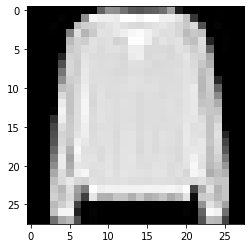

In [ ]:
# select any random index from 1 to 48000
i = random.randint(1,48000)
plt.imshow(X_train[i] , cmap = 'gray')
print('Dimensiones del conjunto de entrenamiento: ', X_train.shape)
print('Dimensiones del conjunto de test: ',    X_test.shape)

num_data, nrows, ncols = X_train.shape

Revisamos tambien un conjunto mas grande de imagenes para observar los otros tipos de productos del conjunto.

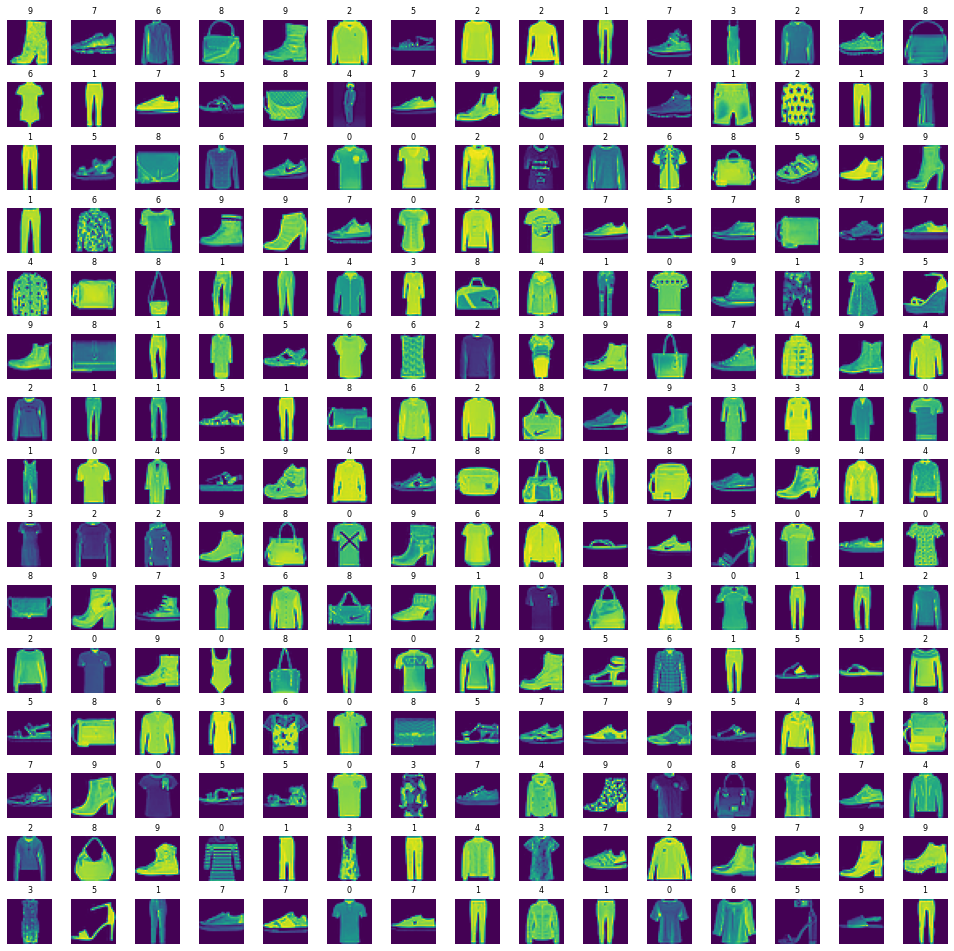

In [ ]:
W_grid = 15
L_grid = 15

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_training = len(X_train) # get the length of the training dataset

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow( X_train[index] )
    axes[i].set_title(y_train[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [ ]:
n_training

48000

## **3. Preparación de datos**
Definimos los variables que utilizaremos durante el entrenamiento de nuestras redes neuronales. Hacemos los reshape necesarios para ajustar las imagenes a las entradas de la red neuronal. Normalizamos los datos para tener mas opciones al momento de seleccionar la función de activación. 

In [ ]:
# tuning parameters
batch_size = 128
num_classes = 10
epochs = 20

In [ ]:
# input image dimensions
img_rows, img_cols = 28, 28

In [ ]:
# reshape our datai
if K.image_data_format() == 'channels_first': 
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'testing samples')

X_train shape: (48000, 28, 28, 1)
48000 training samples
10000 testing samples


In [ ]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## **4. Modelamiento, Entrenamiento y Evaluación Perceptron Multicapa**
Modelamos y entrenamos nuestro perceptron multicapa. Agregamps capas convolusionales con un kernel plano para nuestras imagenes en escala de grises y capas de pooling para reducir la carga computacional, de memoria y el número de parametros.

In [ ]:
model = Sequential()

#Add Layers to the Neural Network
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu', name='encoded'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation=Activation(tf.nn.softmax)))

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(), metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
375/375 [==============================] - 259s 690ms/step - loss: 2.2584 - accuracy: 0.1583 - val_loss: 2.2092 - val_accuracy: 0.2544
Epoch 2/20
375/375 [==============================] - 258s 687ms/step - loss: 2.1660 - accuracy: 0.2450 - val_loss: 2.0821 - val_accuracy: 0.2879
Epoch 3/20
375/375 [==============================] - 260s 692ms/step - loss: 2.0152 - accuracy: 0.3410 - val_loss: 1.8700 - val_accuracy: 0.4556
Epoch 4/20
375/375 [==============================] - 258s 689ms/step - loss: 1.7939 - accuracy: 0.4323 - val_loss: 1.5833 - val_accuracy: 0.5794
Epoch 5/20
375/375 [==============================] - 258s 689ms/step - loss: 1.5664 - accuracy: 0.4870 - val_loss: 1.3330 - val_accuracy: 0.6091
Epoch 6/20
375/375 [==============================] - 258s 688ms/step - loss: 1.4042 - accuracy: 0.5200 - val_loss: 1.1743 - val_accuracy: 0.6354
Epoch 7/20
375/375 [==============================] - 258s 688ms/step - loss: 1.2952 - accuracy: 0.5476 - val_loss: 1.0751 -

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

Test Loss: 0.7539536952972412
Test Accuracy: 0.7268000245094299


En general observamos que las metricas generadas con nuestro modelo son lo suficiente buenas.

## **5. Modelamiento, Entrenamiento y Evaluación Auto Encoder**
En esta seccion entrenamos un autoencoder y hacemos algunas predicciones con este. No sera el que utilicemos para la construcción del perceptron pero nos seguimos familiarizando con este tipo de red neuronal.

In [ ]:
from tensorflow.keras import Input, Model

In [ ]:
encoding_dim = 15 
input_img = Input(shape=(784,))
# encoded representation of input
encoded = Dense(encoding_dim, activation='relu', name="encoded")(input_img)
# decoded representation of code 
decoded = Dense(784, activation='sigmoid')(encoded)
# Model which take input image and shows decoded images
autoencoder = Model(input_img, decoded)

In [ ]:
# This model shows encoded images
encoder = Model(input_img, encoded)
# Creating a decoder model
encoded_input = Input(shape=(encoding_dim,))
# last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Para poder probar los modelos individualmente se hizo un reimport de los datos.

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=33)

Nuevamente se normalizan y se hace un reshape.

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Se entrena el modelo.

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, x_test))

Epoch 1/20
469/469 [==============================] - 3s 5ms/step - loss: 0.3999 - val_loss: 0.3415
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3268 - val_loss: 0.3200
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3126 - val_loss: 0.3111
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3060 - val_loss: 0.3062
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3030 - val_loss: 0.3042
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3016 - val_loss: 0.3032
Epoch 7/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3008 - val_loss: 0.3027
Epoch 8/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3004 - val_loss: 0.3024
Epoch 9/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3000 - val_loss: 0.3020
Epoch 10/20
469/469 [==============================] - 2s 5ms/step - loss: 0.2997 - val_loss: 0.3017

Realizamos predicciones con algunas imagenes. Obtuvimos buenos resultados en nuestras métricas.

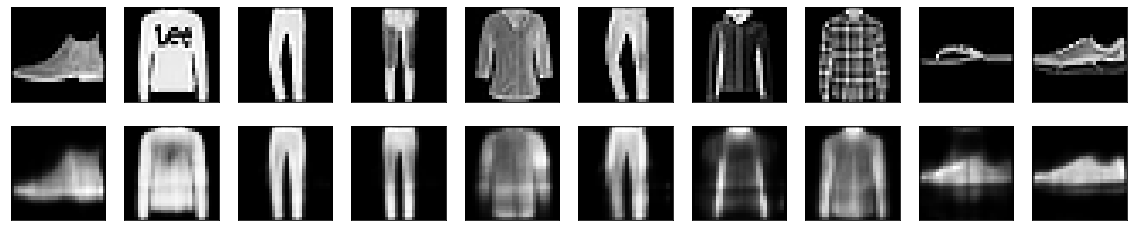

In [ ]:
encoded_img = encoder.predict(x_test)
decoded_img = decoder.predict(encoded_img)
plt.figure(figsize=(20, 4))
for i in range(10):
    # Display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(decoded_img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## **6. Modelamiento, Entrenamiento y Evaluación Auto Encoder + Perceptron** 
En esta seccion usaremos transferencia de conocimientos entre el autoencoder y el perceptron multicapa. La arquitectura de este autoencoder es algo diferente al de la sección anterior.

In [ ]:
model = Sequential()
# encoder network
model.add(Conv2D(30, 3, activation= 'relu', padding='same', input_shape = (28,28,1)))
model.add(MaxPooling2D(2, padding= 'same'))
model.add(Conv2D(15, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))
#decoder network
model.add(Conv2D(15, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(30, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(1,3,activation='sigmoid', padding= 'same', name='decoder')) # output layer

model.compile(optimizer= 'adam', loss = 'binary_crossentropy')

Nuevamente se hace un reimport, normalización y reshape. Se entrena el autoencoder.

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
model.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, x_test))

Epoch 1/20
469/469 [==============================] - 96s 203ms/step - loss: 0.3068 - val_loss: 0.2811
Epoch 2/20
469/469 [==============================] - 96s 204ms/step - loss: 0.2752 - val_loss: 0.2745
Epoch 3/20
469/469 [==============================] - 95s 203ms/step - loss: 0.2709 - val_loss: 0.2717
Epoch 4/20
469/469 [==============================] - 95s 203ms/step - loss: 0.2684 - val_loss: 0.2693
Epoch 5/20
469/469 [==============================] - 95s 203ms/step - loss: 0.2662 - val_loss: 0.2674
Epoch 6/20
469/469 [==============================] - 95s 202ms/step - loss: 0.2644 - val_loss: 0.2658
Epoch 7/20
469/469 [==============================] - 95s 203ms/step - loss: 0.2630 - val_loss: 0.2645
Epoch 8/20
469/469 [==============================] - 95s 203ms/step - loss: 0.2618 - val_loss: 0.2633
Epoch 9/20
469/469 [==============================] - 95s 203ms/step - loss: 0.2608 - val_loss: 0.2624
Epoch 10/20
469/469 [==============================] - 95s 203ms/step - l

Se observan que las metricas son buenas. Se hacen predicciones con algunas imagenes y aqui podemos observar como las imagenes son bien reconstruidas por el autoencoder.

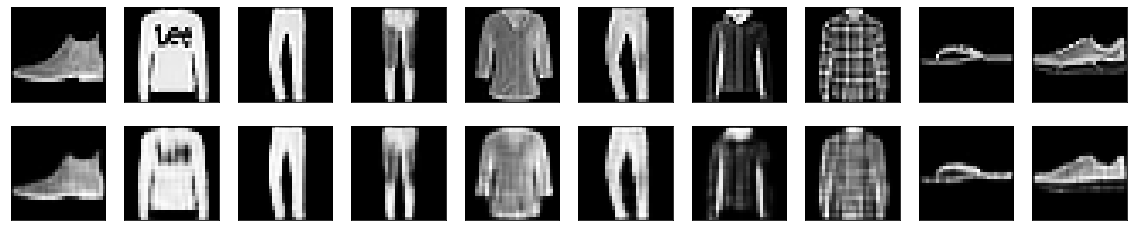

In [ ]:
pred = model.predict(x_test)
plt.figure(figsize=(20, 4))
for i in range(10):
    # Display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Hacemos transferencia de conocimientos separando parte de nuestro autoencoder.

In [ ]:
modelb = Sequential(name='Decoder')

for layers in model.layers:
  print(layers.name)
  layers.trainable = False
  modelb.add(layers)
  if layers.name == "decoder":
    break

conv2d_2
max_pooling2d_1
conv2d_3
max_pooling2d_2
conv2d_4
up_sampling2d
conv2d_5
up_sampling2d_1
decoder


Agregamos la capa de nuestro perceptron y entrenamos el nuevo modelo.

In [ ]:
modelb.add(Dense(num_classes, activation=Activation(tf.nn.softmax)))

In [ ]:
modelb.compile(optimizer= 'adam', loss = 'binary_crossentropy')

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
modelb.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, x_test))

Epoch 1/20
469/469 [==============================] - 41s 86ms/step - loss: 0.7348 - val_loss: 0.7358
Epoch 2/20
469/469 [==============================] - 40s 86ms/step - loss: 0.7340 - val_loss: 0.7357
Epoch 3/20
469/469 [==============================] - 41s 87ms/step - loss: 0.7339 - val_loss: 0.7357
Epoch 4/20
469/469 [==============================] - 40s 86ms/step - loss: 0.7339 - val_loss: 0.7356
Epoch 5/20
469/469 [==============================] - 41s 86ms/step - loss: 0.7339 - val_loss: 0.7356
Epoch 6/20
469/469 [==============================] - 41s 86ms/step - loss: 0.7339 - val_loss: 0.7356
Epoch 7/20
469/469 [==============================] - 41s 87ms/step - loss: 0.7339 - val_loss: 0.7356
Epoch 8/20
469/469 [==============================] - 41s 87ms/step - loss: 0.7339 - val_loss: 0.7356
Epoch 9/20
469/469 [==============================] - 41s 86ms/step - loss: 0.7339 - val_loss: 0.7356
Epoch 10/20
469/469 [==============================] - 41s 87ms/step - loss: 0.733

In [ ]:
score = modelb.evaluate(x_test, x_test, verbose=0)
print('Test Loss:', score)

Test Loss: 0.7356325387954712


## **7. Modelamiento, Entrenamiento y Evaluación  Denoising Auto Encoder + Perceptron** 

Nuevamente se hace un reimport, normalización y reshape. 

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Tomamos solo el 10% de nuestros datos.

In [ ]:
#Tomar el 10% de los datos
n = 54000
x_train = x_train[n:]
y_train = y_train[n:]
print('Dimensiones del conjunto de entrenamiento: ', x_train.shape)

Dimensiones del conjunto de entrenamiento:  (6000, 28, 28, 1)


Creamos nuestros datos con ruido y visualizamos como se genera este ruido.

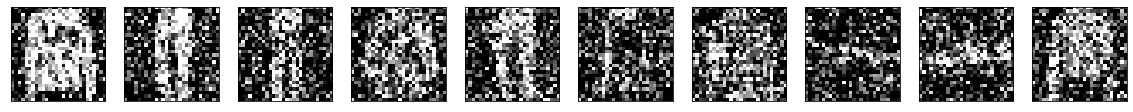

In [ ]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

plt.figure(figsize=(20, 2))
for i in range(1, 10 + 1):
    ax = plt.subplot(1, 10, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Realizamos transferencia de conocimiento agregando capas a nuestro nuevo modelo.

In [ ]:
modelc = Sequential(name='Decoder')

for layers in model.layers:
  print(layers.name)
  layers.trainable = False
  modelc.add(layers)
  if layers.name == "decoder":
    break

conv2d_2
max_pooling2d_1
conv2d_3
max_pooling2d_2
conv2d_4
up_sampling2d
conv2d_5
up_sampling2d_1
decoder


Realizamos el entrenamiento del modelo.

In [ ]:
modelc.compile(optimizer= 'adam', loss = 'binary_crossentropy')

In [ ]:
modelc.fit(x_train_noisy, x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test_noisy, x_test))

Epoch 1/20
47/47 [==============================] - 6s 133ms/step - loss: 0.4141 - val_loss: 0.4147
Epoch 2/20
47/47 [==============================] - 6s 129ms/step - loss: 0.4141 - val_loss: 0.4147
Epoch 3/20
47/47 [==============================] - 6s 130ms/step - loss: 0.4141 - val_loss: 0.4147
Epoch 4/20
47/47 [==============================] - 6s 131ms/step - loss: 0.4141 - val_loss: 0.4147
Epoch 5/20
47/47 [==============================] - 6s 131ms/step - loss: 0.4141 - val_loss: 0.4147
Epoch 6/20
47/47 [==============================] - 6s 132ms/step - loss: 0.4141 - val_loss: 0.4147
Epoch 7/20
47/47 [==============================] - 6s 131ms/step - loss: 0.4141 - val_loss: 0.4147
Epoch 8/20
47/47 [==============================] - 6s 132ms/step - loss: 0.4141 - val_loss: 0.4147
Epoch 9/20
47/47 [==============================] - 6s 131ms/step - loss: 0.4141 - val_loss: 0.4147
Epoch 10/20
47/47 [==============================] - 6s 131ms/step - loss: 0.4141 - val_loss: 0.4147

Se hacen predicciones con algunas imagenes y aqui podemos observar como las imagenes son bien reconstruidas por el noise autoencoder. No es tan bueno como el autoencoder sin ruido.

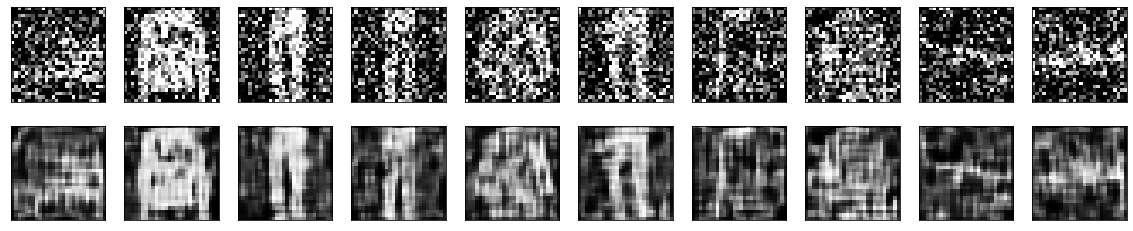

In [ ]:
pred = modelc.predict(x_test_noisy)
plt.figure(figsize=(20, 4))
for i in range(10):
    # Display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Ahora agregamos las capas de nuestro perceptron multicapa y realizamos el entrenamiento con este modelo.

In [ ]:
modelc2 = Sequential(name='Decoder')

for layers in model.layers:
  print(layers.name)
  layers.trainable = False
  modelc2.add(layers)
  if layers.name == "decoder":
    break

conv2d_2
max_pooling2d_1
conv2d_3
max_pooling2d_2
conv2d_4
up_sampling2d
conv2d_5
up_sampling2d_1
decoder


In [ ]:
modelc2.add(Dense(num_classes, activation=Activation(tf.nn.softmax)))

In [ ]:
modelc2.compile(optimizer= 'adam', loss = 'binary_crossentropy')

In [ ]:
modelc2.fit(x_train_noisy, x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test_noisy, x_test))

Epoch 1/20
47/47 [==============================] - 9s 179ms/step - loss: 0.7494 - val_loss: 0.7427
Epoch 2/20
47/47 [==============================] - 8s 176ms/step - loss: 0.7453 - val_loss: 0.7396
Epoch 3/20
47/47 [==============================] - 8s 176ms/step - loss: 0.7428 - val_loss: 0.7378
Epoch 4/20
47/47 [==============================] - 8s 176ms/step - loss: 0.7415 - val_loss: 0.7369
Epoch 5/20
47/47 [==============================] - 8s 174ms/step - loss: 0.7408 - val_loss: 0.7364
Epoch 6/20
47/47 [==============================] - 8s 174ms/step - loss: 0.7405 - val_loss: 0.7362
Epoch 7/20
47/47 [==============================] - 8s 175ms/step - loss: 0.7403 - val_loss: 0.7361
Epoch 8/20
47/47 [==============================] - 8s 173ms/step - loss: 0.7402 - val_loss: 0.7361
Epoch 9/20
47/47 [==============================] - 8s 175ms/step - loss: 0.7402 - val_loss: 0.7360
Epoch 10/20
47/47 [==============================] - 8s 175ms/step - loss: 0.7402 - val_loss: 0.7360

In [ ]:
score = modelb.evaluate(x_test, x_test, verbose=0)
print('Test Loss:', score)

Test Loss: 0.7356325387954712


# **PROBLEMA 2**

## **1. Importación de las librerias requeridas** 
Se importan las librerias necesarias para el desarrollo del problema. Importan librerias que nos ayudaran a hacer el analisis y perfilamiento de los datos.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec

## **2. Perfilamiento y Entendimiento de datos**
Realizamos la lectura de los datos y examinamos el head de la tabla. 

In [ ]:
data = pd.read_csv('./creditcard.csv')

In [ ]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


La columna 'Class' indica si la operación es fraudulenta o no. Revisamos cuantos datos hay en total y el número de atributos para nuestro conjunto de datos

In [ ]:
print(f'Registros:',data.shape[0],' Columnas:',data.shape[1])

Registros: 284807  Columnas: 31


Ahora queremos saber si hay nulos y darles el manejo necesario.

In [ ]:
print(f'Nulos:',data.isnull().sum())

Nulos: Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


No se encontraron datos nulos

Lo siguiente es ver cuantos datos hay para cada una de nuestras clases.

In [ ]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Realizamos un diagrama para observar la distribución de las clases.

Text(0, 0.5, 'Frecuencia')

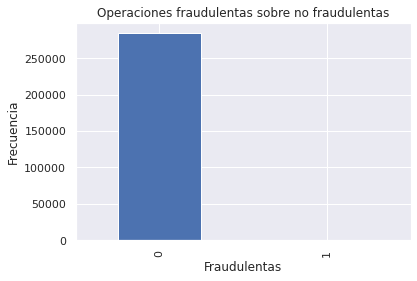

In [ ]:
count_classes = pd.value_counts(data['Class'], sort = False)
count_classes.plot (kind='bar')
plt.title ("Operaciones fraudulentas sobre no fraudulentas")
plt.xlabel ("Fraudulentas")
plt.ylabel ("Frecuencia")

In [ ]:
por = (data.Time[data['Class'] == 1].count() / data.Time[data['Class'] == 0].count())*100
print(f'Porcentaje de trasacciones fraudulentas:', por)

Porcentaje de trasacciones fraudulentas: 0.17304750013189596


Este conjunto de datos solo tiene un 0.17% de datos para nuestra clase de interes. Realiazamos un entendimiento sobre los datos de cada una de las clases individualmente.

In [ ]:
print("Fraudulentos")
print(data[data['Class']==1].describe())
print("Buenos")
print(data[data['Class']==0].describe())

Fraudulentos
                Time          V1          V2  ...         V28       Amount  Class
count     492.000000  492.000000  492.000000  ...  492.000000   492.000000  492.0
mean    80746.806911   -4.771948    3.623778  ...    0.075667   122.211321    1.0
std     47835.365138    6.783687    4.291216  ...    0.547291   256.683288    0.0
min       406.000000  -30.552380   -8.402154  ...   -1.869290     0.000000    1.0
25%     41241.500000   -6.036063    1.188226  ...   -0.108868     1.000000    1.0
50%     75568.500000   -2.342497    2.717869  ...    0.146344     9.250000    1.0
75%    128483.000000   -0.419200    4.971257  ...    0.381152   105.890000    1.0
max    170348.000000    2.132386   22.057729  ...    1.779364  2125.870000    1.0

[8 rows x 31 columns]
Buenos
                Time             V1  ...         Amount     Class
count  284315.000000  284315.000000  ...  284315.000000  284315.0
mean    94838.202258       0.008258  ...      88.291022       0.0
std     47484.015786 

La columna de "Time", nos resulta de interes. La separamos de las demas para observarla con mayor facilidad.

In [ ]:
print('Fraud')
print (data.Time[data.Class == 1].describe())
print()
print('Normal')
print(data.Time[data.Class == 0].describe())

Fraud
count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64

Normal
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


Para seleccioar variables de interes realizamos un analisis de correlación entre variables, necesitamos hacer una estandarizacion de estas mediante un reshape. Importamos las librerias necesarias.

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['Scaled_Amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['Scaled_Time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

In [ ]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Scaled_Amount,Scaled_Time
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1.783274,-0.994983
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.269825,-0.994983
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,4.983721,-0.994972
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1.418291,-0.994972
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.670579,-0.994960


Realizamps la correlación y las ordenamos.

In [ ]:
corr = data.iloc[:,:].corr().sort_values(by='Class',ascending=False).round(2)

In [ ]:
corr

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Scaled_Amount,Scaled_Time
Class,-0.01,-0.10,0.09,-0.19,0.13,-0.09,-0.04,-0.19,0.02,-0.10,-0.22,0.15,-0.26,-0.00,-0.30,-0.00,-0.20,-0.33,-0.11,0.03,0.02,0.04,0.00,-0.00,-0.01,0.00,0.00,0.02,0.01,0.01,1.00,0.01,-0.01
V11,-0.25,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.15,0.00,-0.25
V4,-0.11,0.00,-0.00,-0.00,1.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.10,0.13,0.10,-0.11
V2,-0.01,0.00,1.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.53,0.09,-0.53,-0.01
V21,0.04,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,1.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.11,0.04,0.11,0.04
V19,0.03,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,1.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.06,0.03,-0.06,0.03
V20,-0.05,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,1.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.34,0.02,0.34,-0.05
V8,-0.04,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,1.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.10,0.02,-0.10,-0.04
V27,-0.01,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,1.00,-0.00,0.03,0.02,0.03,-0.01
V28,-0.01,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,1.00,0.01,0.01,0.01,-0.01


Seleccionamos las variables con mayor correlación

In [ ]:
abscorr = corr[abs(corr['Class']) > 0.15].index

In [ ]:
abscorr

Index(['Class', 'V7', 'V3', 'V16', 'V10', 'V12', 'V14', 'V17'], dtype='object')

Realizamos un mapa de correlación con las variables seleccionadas

In [ ]:
cm = np.corrcoef(data[abscorr].values.T)

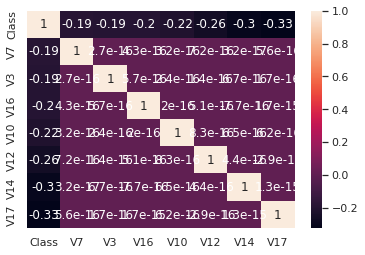

In [ ]:
sns.set(font_scale=1)
hm = sns.heatmap(cm,annot=True,yticklabels=abscorr.values, xticklabels=abscorr.values)
plt.show()

Creamos un dataframe con las variables seleccionadas.

In [ ]:
df = data.loc[:,['Time','V17','V14','V12','V10','V16','V3','V7','V18','V4','Amount','Class']]

In [ ]:
df.head()

,Time,V17,V14,V12,V10,V16,V3,V7,V18,V4,Amount,Class
0,0.0,0.207971,-0.311169,-0.617801,0.090794,-0.470401,2.536347,0.239599,0.025791,1.378155,149.62,0
1,0.0,-0.114805,-0.143772,1.065235,-0.166974,0.463917,0.166480,-0.078803,-0.183361,0.448154,2.69,0
2,1.0,1.109969,-0.165946,0.066084,0.207643,-2.890083,1.773209,0.791461,-0.121359,0.379780,378.66,0
3,1.0,-0.684093,-0.287924,0.178228,-0.054952,-1.059647,1.792993,0.237609,1.965775,-0.863291,123.50,0
4,2.0,-0.237033,-1.119670,0.538196,0.753074,-0.451449,1.548718,0.592941,-0.038195,0.403034,69.99,0


Queremos observar el comportamiento de nuestros datos segun la variable tiempo.

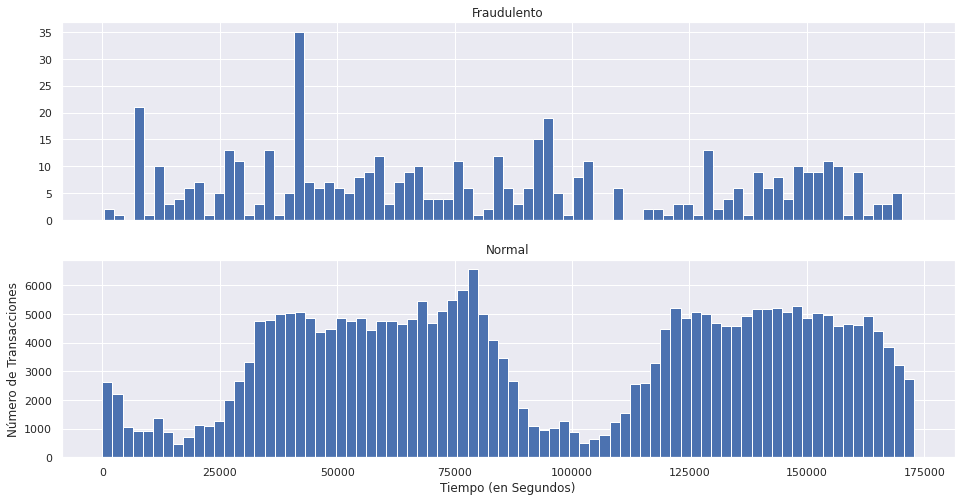

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,8))

ax1.hist(df.Time[df.Class == 1], bins = 80)
ax1.set_title('Fraudulento')

ax2.hist(df.Time[df.Class == 0], bins = 80)
ax2.set_title('Normal')

plt.xlabel('Tiempo (en Segundos)')
plt.ylabel('Número de Transacciones')
plt.show()

Se puede observar que los casos fraudulentos estan más normalizados, y los normales tienen picos de horas de alto tráfico

## **3. Modelamiento, Entrenamiento y Evaluación**

Selección de columnas en un nuevo dataframe.

In [ ]:
df2 = data.loc[:,['V17','V14','V12','V10','V16','V3','V7','V18','V4','Scaled_Amount','Class']]

Separamos los datos en dos arrays, uno con las variables X y otro con las variables y

In [ ]:

X = df2.iloc[:, df2.columns != 'Class']
y = df2.iloc[:, df2.columns == 'Class']

Antes de construir nuestro modelo, necesitamos balancear los datos haciendo resampling. En este caso vamos a realizar undersampling. Se hace un conteo del número de datos fraudulentos y se guardan los indices donde estan los datos de ambas clases.

In [ ]:
number_records_fraud = len (df2[df2.Class==1])
fraud_indices = np.array (df2[df2.Class==1].index)
normal_indices = np.array (df2[df2.Class==0].index)

Obtenemosde forma aleatoria un indice para no fraudulentos del mismo tamaño que el de los fraudulentos y lo unimos en un mismo array.

In [ ]:
random_normal_indices = np.random.choice (normal_indices, number_records_fraud, replace = False )
under_sample_indices = np.concatenate ([fraud_indices, random_normal_indices])

Se asignan valores a los indices y se separan  nuevamente las variables en dos arrays, uno con las variables X y otro con las variables y. 

In [ ]:
under_sample_data = df2.iloc[under_sample_indices,:]

X_undersample = under_sample_data.iloc [:, under_sample_data.columns != 'Class'];
y_undersample = under_sample_data.iloc [:, under_sample_data.columns == 'Class'];


print('Transacciones:', len(under_sample_indices));

Transacciones: 984


Ahora se construye el modelo  y se hace el entrenamiento. Decidimos usar un perceptron multicapa constuido con la asistencia de sklearn.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 0)
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split (X_undersample,y_undersample, test_size = 0.3, random_state = 0)

In [ ]:
from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier

In [ ]:
MLPC = MLPClassifier(hidden_layer_sizes=(200,), max_iter=10000)
MLPC.fit(X_train_under, y_train_under)
y_pred = MLPC.predict(X_test)
# Obtenemos valores de recall
recall_acc = recall_score (y_test,y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(recall_acc)

0.9727891156462585


Obtuvimos un muy buen valor para nuestra métrica de recall. Esta es la métrica de mayor importancia ya que nos interesa que las transacciones que realmente son fraudulentas sean detectadas.